導入資料 初步檢查

In [23]:
import warnings
warnings.filterwarnings("ignore")  # 屏蔽 warning

%matplotlib inline

import pandas as pd

df = pd.read_csv('./dataset/train.csv')
print(df.shape)  # 输出 (行数, 列数)
print(df.head(5))

(27643, 3)
   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


預處理資料

In [1]:

import os
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from scipy import sparse as sp

# sklearn
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# text / nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag, word_tokenize, ne_chunk

# 并行（可选）
from joblib import Parallel, delayed

# ========== NLTK 资源准备 ==========
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find('chunkers/maxent_ne_chunker')
except LookupError:
    nltk.download('maxent_ne_chunker')
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')

# ========== 小工具与常量 ==========
_BODY_OPEN = re.compile(
    r'(?is)<\s*(section|div|article)\b[^>]*\b'
    r'(?:article-content|article-body|content-body|post-content)\b[^>]*>'
)

_MONTH = dict(jan='01', feb='02', mar='03', apr='04', may='05', jun='06',
              jul='07', aug='08', sep='09', oct='10', nov='11', dec='12')

def _norm(s: str) -> str:
    return re.sub(r'[\W]+', ' ', (s or '').lower()).strip()

def _slug(s: str) -> str:
    return re.sub(r'[^a-z0-9_]+', '', _norm(s).replace(' ', '_'))

def _bucket(n, edges):
    if n is None:
        return 'unk'
    for i in range(len(edges)-1):
        if edges[i] <= n < edges[i+1]:
            return f"b{edges[i]}_{edges[i+1]}"
    return f"b{edges[-1]}p"

def _aspect_bucket(w, h):
    if not w or not h:
        return 'unk'
    r = w / h
    if r < 0.9: return 'tall'
    if r < 1.2: return 'squareish'
    if r < 1.8: return 'landscape'
    return 'ultrawide'

def _img_size_bucket(w, h):
    if not w or not h:
        return 'unk'
    area = w * h
    if area < 80_000: return 'xs'
    if area < 230_000: return 'sm'
    if area < 920_000: return 'md'
    if area < 2_100_000: return 'lg'
    return 'xl'

def _parse_wh_from_src(src: str):
    if not src:
        return None, None
    m = re.search(r'/(\d{2,5})x(\d{2,5})/', src)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None, None

# 模拟热词（保持你的设定）
TRENDING_TOPICS = {
    'elon_musk', 'ai', 'climate_change', 'covid', 'blockchain', 'taiwan',
    'tesla', 'space', 'crypto', 'elections'
}

# ========== 预训练 LDA ==========
def pretrain_lda(df, column='Page content', n_components=10, max_features=1000, max_text_len=500):
    """预训练 LDA（对 header 文本做 Count -> LDA），返回 vectorizer 与 lda 模型"""
    def extract_text(html):
        if not isinstance(html, str) or not html.strip():
            return ""
        m = _BODY_OPEN.search(html)
        header_html = html[:m.start()] if m else html
        soup = BeautifulSoup(header_html, 'html.parser')
        return ' '.join(soup.get_text().lower().split()[:max_text_len])

    corpus = [extract_text(html) for html in df[column] if isinstance(html, str)]
    corpus = [text if text else "" for text in corpus]
    if not corpus:
        print("警告：语料为空，跳过 LDA 预训练")
        return None, None

    vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
    lda.fit(X)
    return vectorizer, lda

# ========== 增强版预处理（与你提供的一致，仅少量防御性 try/except） ==========
porter = PorterStemmer()
STOP = set(stopwords.words('english'))

def preprocessor(html: str, lda_vectorizer=None, lda_model=None, max_text_len=500) -> tuple:
    if not isinstance(html, str) or not html.strip():
        return "empty_content", set(), "author_unknown channel_unknown publisher_unknown"

    # A) 仅保留 header（正文前）
    m = _BODY_OPEN.search(html)
    header_html = html[:m.start()] if m else html

    soup = BeautifulSoup(header_html, 'html.parser')

    # 标题
    title_raw = None
    h1 = soup.find('h1', class_=lambda c: (isinstance(c, list) and any('title' in x for x in c)) or (isinstance(c, str) and 'title' in c)) \
         or soup.find('h1')
    if h1:
        title_raw = h1.get_text(' ', strip=True)
    elif soup.title:
        title_raw = soup.title.get_text(' ', strip=True)
    title_tokens = _norm(title_raw)

    # 作者
    author = None
    by = soup.find(class_=lambda c: c and ('byline' in c or 'author_name' in c))
    if by:
        author = by.get_text(' ', strip=True)
    if not author:
        a = soup.find('a', href=re.compile(r'/author/[^/]+/?$', re.I))
        if a:
            author = a.get_text(' ', strip=True)
    author_slug = _slug(re.sub(r'^\s*by\s+', '', author or '', flags=re.I))

    # 频道
    channel = None
    art = soup.find('article')
    if art and art.has_attr('data-channel'):
        channel = art['data-channel']
    if not channel and art:
        cls = ' '.join(art.get('class', []))
        mch = re.search(r'\b(news|tech|world|sports?|business|entertainment|culture|life|science)\b', cls, re.I)
        if mch: channel = mch.group(1)
    channel_slug = _slug(channel or 'unknown')

    # 发布者
    publisher = None
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub:
        publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)
    publisher_slug = _slug(publisher or 'unknown')

    # 时间
    year = month = weekday = tod = season = None
    is_weekend = None
    tm = soup.find('time')
    dt = tm['datetime'] if (tm and tm.has_attr('datetime')) else (tm.get_text(' ', strip=True) if tm else None)
    if dt:
        y = re.search(r'(20\d{2}|19\d{2})', dt)
        if y: year = y.group(1)
        mo = re.search(r'-(\d{2})-', dt) or re.search(r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', dt, re.I)
        if mo:
            mm = mo.group(1).lower() if mo.lastindex else mo.group(0).lower()
            month = _MONTH.get(mm, mm)
        wd = re.search(r'\b(mon|tue|wed|thu|fri|sat|sun)\b', dt, re.I)
        if wd:
            weekday = wd.group(1).lower()
            is_weekend = weekday in ('sat', 'sun')
        hh = re.search(r'\b(\d{2}):(\d{2})', dt)
        if hh:
            h = int(hh.group(1))
            tod = 'morning' if 5 <= h < 12 else 'afternoon' if 12 <= h < 17 else 'evening' if 17 <= h < 22 else 'night'
        if month:
            m_i = int(month)
            season = 'spring' if 3 <= m_i <= 5 else 'summer' if 6 <= m_i <= 8 else 'autumn' if 9 <= m_i <= 11 else 'winter'

    # 媒体/结构
    imgs = soup.find_all('img')
    img_count = len(imgs)
    has_image = img_count > 0
    leadimg = soup.find(attrs={'data-fragment': 'lead-image'}) is not None
    max_w = max_h = None
    for im in imgs:
        w, h = _parse_wh_from_src(im.get('src', ''))
        if w and h:
            if not max_w or (w * h) > (max_w * max_h if (max_w and max_h) else 0):
                max_w, max_h = w, h
    img_size_bucket = _img_size_bucket(max_w, max_h)
    img_aspect_bucket = _aspect_bucket(max_w, max_h)

    videos = soup.find_all('video')
    iframes = soup.find_all('iframe')
    has_video = bool(videos) or any(re.search(r'(youtube|vimeo|dailymotion)', (fr.get('src') or ''), re.I) for fr in iframes)
    audio = soup.find_all('audio')
    has_audio = len(audio) > 0
    interactive_elements = soup.find_all(['canvas', 'svg', lambda tag: tag.name == 'div' and 'interactive' in (tag.get('class') or [])])
    has_interactive = len(interactive_elements) > 0
    link_count = len(soup.find_all('a'))
    link_bucket = _bucket(link_count, [0, 1, 3, 6, 10])
    img_bucket = _bucket(img_count, [0, 1, 3, 5])

    authoritative_domains = ['.edu', '.gov', '.org']
    authoritative_links = sum(1 for a in soup.find_all('a') if any(domain in (a.get('href') or '').lower() for domain in authoritative_domains))
    authoritative_link_bucket = _bucket(authoritative_links, [0, 1, 3, 5])

    # 标题形态
    raw = title_raw or ''
    title_has_num = bool(re.search(r'\d', raw))
    title_has_year = bool(re.search(r'\b(19|20)\d{2}\b', raw))
    title_has_q = '?' in raw
    title_has_exclaim = '!' in raw
    title_has_colon = ':' in raw
    is_listicle = bool(re.match(r'^\s*\d+', raw))
    upper_ratio = (sum(ch.isupper() for ch in raw) / max(1, sum(ch.isalpha() for ch in raw)))
    upper_bucket = 'low' if upper_ratio < 0.15 else 'mid' if upper_ratio < 0.4 else 'high'
    title_word_len = len(_norm(raw).split())
    title_char_len = len(re.sub(r'\s+', '', raw))
    tw_bucket = _bucket(title_word_len, [0, 4, 8, 12, 20])
    tc_bucket = _bucket(title_char_len, [0, 30, 60, 90, 140])

    # 社交信号
    social_keywords = ['share', 'twitter', 'facebook', 'linkedin', 'whatsapp', 'telegram']
    social_elements = soup.find_all(lambda tag: any(
        keyword in (tag.get('class') or []) or
        keyword in (tag.get('id') or '') or
        keyword in (tag.get_text().lower())
        for keyword in social_keywords
    ))
    social_count = len(social_elements)
    social_count_bucket = _bucket(social_count, [0, 1, 3, 5])

    share_count = 0
    for elem in social_elements:
        text = elem.get_text().lower()
        m = re.search(r'(\d+)\s*(shares?|likes?|retweets?)', text, re.I)
        if m:
            share_count += int(m.group(1))
    shares_bucket = _bucket(share_count, [0, 10, 100, 1000])

    comment_selectors = ['.comments', '#comments', '.comment', '.discussion']
    comment_count = 0
    for selector in comment_selectors:
        comment_count += len(soup.select(selector))
    comment_count_bucket = _bucket(comment_count, [0, 1, 3, 5])

    # 情感（VADER）
    text_content = ' '.join(soup.get_text().lower().split()[:max_text_len])
    try:
        vader = SentimentIntensityAnalyzer()
        sentiment_scores = vader.polarity_scores(text_content)
        sentiment_compound = sentiment_scores['compound']
    except Exception:
        sentiment_compound = 0.0
    sentiment_bucket = 'strong_positive' if sentiment_compound > 0.5 else 'positive' if sentiment_compound > 0.05 \
        else 'strong_negative' if sentiment_compound < -0.5 else 'negative' if sentiment_compound < -0.05 else 'neutral'

    positive_words = ['amazing', 'great', 'excellent', 'wonderful', 'best', 'success', 'win', 'good', 'positive']
    negative_words = ['terrible', 'awful', 'bad', 'worst', 'failure', 'lose', 'problem', 'negative']
    pos_count = sum(1 for word in positive_words if word in text_content)
    neg_count = sum(1 for word in negative_words if word in text_content)

    # 紧急/问句/名词/CTA
    # —— CTA（Call-To-Action）计数与分桶 ——  ★★ 新增修复
    cta_phrases = ['read more', 'subscribe now', 'click here', 'learn more', 'join us', 'sign up']
    cta_count = sum(1 for phrase in cta_phrases if phrase in text_content)
    cta_count_bucket = _bucket(cta_count, [0, 1, 3, 5])

    urgency_indicators = ['breaking', 'urgent', 'alert', 'crisis', 'emergency', 'important']
    urgency_count = sum(1 for word in urgency_indicators if word in text_content)
    urgency_count_bucket = _bucket(urgency_count, [0, 1, 3, 5])

    question_words = ['what', 'why', 'how', 'when', 'where', 'who']
    question_count = sum(1 for word in question_words if word in text_content)
    question_count_bucket = _bucket(question_count, [0, 1, 3, 5])

    tokens = word_tokenize(text_content)
    try:
        tagged = pos_tag(tokens)
    except Exception:
        tagged = [(w, 'NN') for w in tokens]
    nouns = [word for word, pos in tagged if pos.startswith('NN') and word.lower() not in STOP]
    noun_count = len(nouns)
    noun_count_bucket = _bucket(noun_count, [0, 5, 10, 20, 50])

    # NER
    entities = set()
    try:
        chunked = ne_chunk(tagged)
        for chunk in chunked:
            if hasattr(chunk, 'label') and chunk.label() in ['PERSON', 'ORGANIZATION', 'GPE']:
                entity = '_'.join(c[0].lower() for c in chunk)
                entities.add(f'entity_{entity}')
    except Exception:
        pass
    entity_count = len(entities)
    entity_count_bucket = _bucket(entity_count, [0, 1, 3, 5])

    # LDA 主题
    if lda_vectorizer is not None and lda_model is not None:
        X = lda_vectorizer.transform([text_content] if text_content else [''])
        topic_dist = lda_model.transform(X)
        dominant_topic = int(np.argmax(topic_dist[0])) if topic_dist.size > 0 else 0
        topic_score = float(topic_dist[0][dominant_topic]) if topic_dist.size > 0 else 0.0
        topic_bucket = f'topic_{dominant_topic}_b{_bucket(topic_score, [0, 0.5, 0.7, 0.9])}'
    else:
        topic_bucket = 'topic_unk'

    trending_matches = sum(1 for word in tokens if word.lower() in TRENDING_TOPICS)
    trending_bucket = _bucket(trending_matches, [0, 1, 3, 5])

    # 参与度（模拟）
    engagement_metrics = {'clicks': 0, 'shares': share_count, 'comments': comment_count}
    click_elements = soup.find_all(lambda tag: 'click' in tag.get_text().lower() and re.search(r'\d+', tag.get_text()))
    for elem in click_elements:
        m = re.search(r'(\d+)\s*clicks?', elem.get_text(), re.I)
        if m:
            engagement_metrics['clicks'] += int(m.group(1))
    clicks_bucket = _bucket(engagement_metrics['clicks'], [0, 100, 1000, 10000])
    # 参与度（模拟）
    engagement_metrics = {'clicks': 0, 'shares': share_count, 'comments': comment_count}
    # ...（已有的统计 clicks）
    clicks_bucket = _bucket(engagement_metrics['clicks'], [0, 100, 1000, 10000])

    # ★ 新增修复：给 'comments_' 这条特征计算桶
    comments_bucket = _bucket(engagement_metrics['comments'], [0, 1, 10, 50])


    # 可读性与结构
    try:
        from textstat import flesch_reading_ease
        readability_score = flesch_reading_ease(text_content) if text_content else 0
    except Exception:
        readability_score = 0
    readability_bucket = 'very_easy' if readability_score > 80 else 'easy' if readability_score > 60 \
        else 'standard' if readability_score > 50 else 'difficult' if readability_score > 30 else 'very_difficult'

    div_count = len(soup.find_all('div'))
    section_count = len(soup.find_all('section'))
    list_count = len(soup.find_all(['ul', 'ol']))
    div_count_bucket = _bucket(div_count, [0, 5, 10, 20, 50])
    section_count_bucket = _bucket(section_count, [0, 1, 3, 5])
    list_count_bucket = _bucket(list_count, [0, 1, 3, 5])
    header_word_count = len(text_content.split())
    header_word_count_bucket = _bucket(header_word_count, [0, 50, 100, 200, 500])

    # 拼 meta feats（全部 token 化）
    feats = []
    feats += [
        f'author_{author_slug or "unknown"}',
        f'channel_{channel_slug}',
        f'publisher_{publisher_slug}',
        f'year_{year or "unk"}',
        f'month_{month or "unk"}',
        f'weekday_{weekday or "unk"}',
        f'tod_{tod or "unk"}',
        f'season_{season or "unk"}',
        'weekend' if is_weekend else 'weekday' if is_weekend is not None else 'weekend_unk',
    ]
    feats += [
        'has_image' if has_image else 'no_image',
        f'imgcnt_{img_bucket}',
        'has_leadimg' if leadimg else 'no_leadimg',
        f'imgsize_{img_size_bucket}',
        f'imgaspect_{img_aspect_bucket}',
        'has_video' if has_video else 'no_video',
        'has_audio' if has_audio else 'no_audio',
        'has_interactive' if has_interactive else 'no_interactive',
        f'linkcnt_{link_bucket}',
        f'authoritative_links_{authoritative_link_bucket}',
    ]
    feats += [
        'is_listicle' if is_listicle else 'not_listicle',
        'title_has_num' if title_has_num else 'title_no_num',
        'title_has_year' if title_has_year else 'title_no_year',
        'title_has_q' if title_has_q else 'title_no_q',
        'title_has_exclaim' if title_has_exclaim else 'title_no_exclaim',
        'title_has_colon' if title_has_colon else 'title_no_colon',
        f'title_len_word_{tw_bucket}',
        f'title_len_char_{tc_bucket}',
        f'title_upper_{upper_bucket}',
    ]
    feats += [
        f'social_buttons_{social_count_bucket}',
        f'comment_sections_{comment_count_bucket}',
        f'share_count_{shares_bucket}',
    ]
    feats += [
        f'positive_words_{pos_count}',
        f'negative_words_{neg_count}',
        f'sentiment_{sentiment_bucket}',
    ]
    feats += [
        f'urgency_indicators_{urgency_count_bucket}',
        f'question_words_{question_count_bucket}',
        f'noun_count_{noun_count_bucket}',
        f'cta_count_{cta_count_bucket}',
    ]
    feats += [
        f'div_count_{div_count_bucket}',
        f'section_count_{section_count_bucket}',
        f'list_count_{list_count_bucket}',
        f'readability_{readability_bucket}',
    ]
    feats += [
        f'header_word_count_{header_word_count_bucket}',
    ]
    feats += [
        f'entity_count_{entity_count_bucket}',
        topic_bucket,
        f'trending_matches_{trending_bucket}',
        f'clicks_{clicks_bucket}',
        f'shares_{shares_bucket}',
        f'comments_{comments_bucket}',
    ]
    feats += list(entities)

    return title_tokens, entities, ' '.join(feats)

# ========== 训练数据流 ==========
def get_data_streams(path, train_size=20000, val_size=6000, batch_size=500):
    """按顺序切分 train/val，再按批产生。将 Popularity 从 {-1,1} 映射到 {0,1}。"""
    df = pd.read_csv(path)
    df['Popularity'] = (df['Popularity'].astype(int) == 1).astype(int)

    train_df = df.iloc[:train_size].reset_index(drop=True)
    val_df   = df.iloc[train_size:train_size+val_size].reset_index(drop=True)

    def train_generator():
        for i in range(0, len(train_df), batch_size):
            batch = train_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    def val_generator():
        for i in range(0, len(val_df), batch_size):
            batch = val_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    return train_generator(), val_generator(), len(train_df), len(val_df)

# ========== 词法器（标题/实体）与哈希器（类别分桶） ==========
title_vec = HashingVectorizer(
    n_features=2**19,            # 可调：标题给多一些维度
    alternate_sign=False,
    ngram_range=(1, 2),
    token_pattern=r'(?u)\b\w+\b'
)

entities_vec = HashingVectorizer(
    n_features=2**18,
    alternate_sign=False,
    token_pattern=r'(?u)\b\w+\b'
)

make_hasher = lambda n: FeatureHasher(n_features=2**n, input_type='string', alternate_sign=False)
author_h       = make_hasher(14)
channel_h      = make_hasher(14)
publisher_h    = make_hasher(14)
time_h         = make_hasher(15)
media_h        = make_hasher(14)
titleshape_h   = make_hasher(14)
social_h       = make_hasher(14)
content_h      = make_hasher(14)
structure_h    = make_hasher(14)
length_h       = make_hasher(12)
extra_h        = make_hasher(14)

# ========== 标题分词（沿用你的 stem + 去停用） ==========
def tokenizer_stem_keepmeta(text: str, entities: set) -> list:
    toks = re.split(r'\s+', (text or '').strip())
    out = []
    for w in toks:
        if not w:
            continue
        if '_' in w or any(ch.isdigit() for ch in w) or (w.startswith('entity_') and w[7:] in entities):
            out.append(w)
        elif w.lower() not in STOP and re.fullmatch(r'[a-zA-Z]+', w):
            out.append(porter.stem(w.lower()))
    return out

# ========== 将 feats_string 按前缀分桶 ==========
PREFIX_MAP = {
    'author_':      'author',
    'channel_':     'channel',
    'publisher_':   'publisher',
    'year_':        'time', 'month_': 'time', 'weekday_': 'time',
    'tod_':         'time', 'season_': 'time',
    'weekend':      'time', 'weekday': 'time',

    'has_image':    'media', 'no_image': 'media',
    'imgcnt_':      'media', 'has_leadimg': 'media', 'no_leadimg': 'media',
    'imgsize_':     'media', 'imgaspect_': 'media',
    'has_video':    'media', 'no_video': 'media',
    'has_audio':    'media', 'no_audio': 'media',
    'has_interactive':'media','no_interactive':'media',
    'linkcnt_':     'media', 'authoritative_links_': 'media',

    'is_listicle':  'titleshape', 'not_listicle': 'titleshape',
    'title_has_':   'titleshape',
    'title_len_word_': 'titleshape', 'title_len_char_': 'titleshape',
    'title_upper_': 'titleshape',

    'social_buttons_': 'social',
    'comment_sections_': 'social',
    'share_count_': 'social',

    'urgency_indicators_': 'content',
    'question_words_':     'content',
    'noun_count_':         'content',
    'cta_count_':          'content',

    'div_count_':      'structure',
    'section_count_':  'structure',
    'list_count_':     'structure',
    'readability_':    'structure',

    'header_word_count_': 'length',

    'entity_count_':   'extra',
    'topic_':          'extra',
    'trending_matches_':'extra',
    'clicks_':         'extra',
    'shares_':         'extra',
    'comments_':       'extra',

    'sentiment_':      'extra',
    'positive_words_': 'extra',
    'negative_words_': 'extra',
}

def _split_feat_tokens(feats_string: str):
    buckets = {k: [] for k in [
        'author','channel','publisher','time',
        'media','titleshape','social','content','structure','length','extra'
    ]}
    if not feats_string:
        for k in buckets: buckets[k] = [f'{k}=_none']
        return buckets

    for tok in feats_string.split():
        matched = False
        # 长前缀优先的朴素匹配
        for pref, group in PREFIX_MAP.items():
            if tok.startswith(pref):
                buckets[group].append(tok)
                matched = True
                break
        if not matched:
            buckets['extra'].append(tok)

    for k,v in buckets.items():
        if not v:
            buckets[k] = [f'{k}=_none']
    return buckets

# ========== 多路向量化 + 拼接 ==========
def featurize_split(html_series: pd.Series, lda_vectorizer=None, lda_model=None) -> sp.csr_matrix:
    titles, entity_texts = [], []
    author_tokens, channel_tokens, publisher_tokens = [], [], []
    time_tokens, media_tokens, titleshape_tokens = [], [], []
    social_tokens, content_tokens, structure_tokens = [], [], []
    length_tokens, extra_tokens = [], []

    for html in html_series.astype(str).tolist():
        toks, ents, feats = preprocessor(html, lda_vectorizer, lda_model)
        # 标题（轻度清洗 + 词干）
        title_text = ' '.join(tokenizer_stem_keepmeta(toks, set())) if toks else ''
        titles.append(title_text)
        # 实体（直接拼成文本；ents 已带 entity_ 前缀）
        entity_texts.append(' '.join(sorted(ents)) if ents else '')
        # meta feats 分桶
        buckets = _split_feat_tokens(feats)
        author_tokens.append(buckets['author'])
        channel_tokens.append(buckets['channel'])
        publisher_tokens.append(buckets['publisher'])
        time_tokens.append(buckets['time'])
        media_tokens.append(buckets['media'])
        titleshape_tokens.append(buckets['titleshape'])
        social_tokens.append(buckets['social'])
        content_tokens.append(buckets['content'])
        structure_tokens.append(buckets['structure'])
        length_tokens.append(buckets['length'])
        extra_tokens.append(buckets['extra'])

    # —— 各块编码 ——
    X_title      = title_vec.transform(titles)
    X_entities   = entities_vec.transform(entity_texts)

    X_author     = author_h.transform(author_tokens)
    X_channel    = channel_h.transform(channel_tokens)
    X_publisher  = publisher_h.transform(publisher_tokens)
    X_time       = time_h.transform(time_tokens)
    X_media      = media_h.transform(media_tokens)
    X_titleshape = titleshape_h.transform(titleshape_tokens)
    X_social     = social_h.transform(social_tokens)
    X_content    = content_h.transform(content_tokens)
    X_structure  = structure_h.transform(structure_tokens)
    X_length     = length_h.transform(length_tokens)
    X_extra      = extra_h.transform(extra_tokens)

    # —— 拼接（列顺序固定，随时可替换/调宽度）——  只保留三個！！
    X = sp.hstack([X_title, X_header, X_entities], format='csr')

    return X

# ========== 验证集整量 AUC ==========
def eval_val_auc_full(clf, val_batches, lda_vectorizer=None, lda_model=None):
    all_scores, all_targets = [], []
    for vb in val_batches:
        Xv = featurize_split(vb['Page content'], lda_vectorizer, lda_model)
        if hasattr(clf, "decision_function"):
            sv = clf.decision_function(Xv)
            scores = sv if sv.ndim == 1 else sv[:, 1]
        else:
            # hinge 无 predict_proba；保底
            scores = clf.decision_function(Xv)
        all_scores.append(scores)
        all_targets.append(vb['Popularity'].values)
    y = np.concatenate(all_targets)
    s = np.concatenate(all_scores)
    if np.unique(y).size < 2:
        return np.nan
    return roc_auc_score(y, s)

# ========== 入口 ==========
if __name__ == "__main__":
    TRAIN_PATH = './dataset/train.csv'

    # 预训练 LDA（可选，失败则返回 None，不影响主流程）
    df_all = pd.read_csv(TRAIN_PATH)
    df_all = df_all.dropna(subset=['Page content'])
    df_all['Page content'] = df_all['Page content'].astype(str)
    lda_vectorizer, lda_model = pretrain_lda(df_all, column='Page content', n_components=10, max_features=1000)

    # 数据流
    BATCH_SIZE = 1250
    TRAIN_SIZE = 24000
    VAL_SIZE   = 3000
    train_stream, val_stream, train_size, val_size = get_data_streams(
        TRAIN_PATH, train_size=TRAIN_SIZE, val_size=VAL_SIZE, batch_size=BATCH_SIZE
    )
    iters = int((TRAIN_SIZE + BATCH_SIZE - 1) / BATCH_SIZE)

    # 模型（保守一点的学习率，若你想沿用原 eta0=10000，可改回去）
    classes = np.array([0, 1])
    clf = SGDClassifier(
        loss="log_loss",
        penalty="elasticnet",
        alpha=1e-6,
        l1_ratio=0.15,
        learning_rate="constant",
        eta0=100,          # 原来是 10000，极易发散；这里给稳健默认值
        average=True,
        max_iter=1, tol=None,
        random_state=42
    )

    # 固化验证集批次，便于每步全量评估
    val_batches = list(val_stream)

    EVAL_EVERY = 1
    train_auc_hist, val_auc_hist = [], []

    for i in range(iters):
        try:
            batch = next(train_stream)
        except StopIteration:
            print("训练数据流结束")
            break

        Xtr = featurize_split(batch['Page content'], lda_vectorizer, lda_model)
        ytr = batch['Popularity'].values

        if i == 0:
            clf.partial_fit(Xtr, ytr, classes=classes)
        else:
            clf.partial_fit(Xtr, ytr)

        # 批次内 AUC（仅用于监控）
        if np.unique(ytr).size == 2:
            tr_scores = clf.decision_function(Xtr)
            tr_auc = roc_auc_score(ytr, tr_scores)
        else:
            tr_auc = np.nan
        train_auc_hist.append(tr_auc)

        if (i + 1) % EVAL_EVERY == 0:
            va_auc = eval_val_auc_full(clf, val_batches, lda_vectorizer, lda_model)
            val_auc_hist.append(va_auc)
            print(f"[{i+1}/{iters}] Train AUC: {('%.4f' % tr_auc) if np.isfinite(tr_auc) else 'nan'}, "
                  f"Full Val AUC: {('%.4f' % va_auc) if np.isfinite(va_auc) else 'nan'}")
        else:
            print(f"[{i+1}/{iters}] Train AUC: {('%.4f' % tr_auc) if np.isfinite(tr_auc) else 'nan'}")

    final_val_auc = eval_val_auc_full(clf, val_batches, lda_vectorizer, lda_model)
    print(f"Final Full Val AUC: {final_val_auc:.4f}")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


NameError: name 'X_header' is not defined

繪製學習曲線

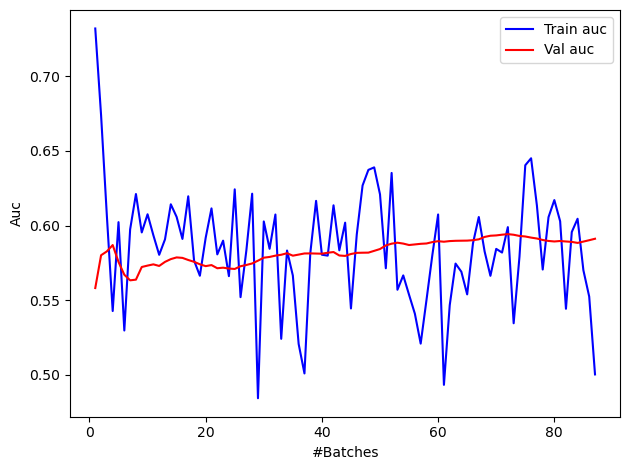

In [10]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc_hist)+1), train_auc_hist, color='blue', label='Train auc')
plt.plot(
    np.linspace(1, len(train_auc_hist), len(val_auc_hist)), 
    val_auc_hist, 
    color='red', 
    label='Val auc'
)
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

定期保存

In [8]:
# ==== 1) 保存训练产物（只需要保存 clf；若用了 LDA，也保存 LDA 二件套） ====
import os, _pickle as pkl
os.makedirs('output', exist_ok=True)

pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))
pkl.dump({'lda_vec': lda_vectorizer, 'lda_model': lda_model}, open('output/lda.pkl', 'wb'))
print('Saved to output/clf-sgd.pkl and output/lda.pkl')

# ==== 2) （可在新会话）加载并推理 test ====
import _pickle as pkl
import numpy as np
import pandas as pd
from scipy.special import expit  # 稳定的 sigmoid

# 确保 featurize_split(...) 和 preprocessor(...) 已在当前会话中定义好
clf = pkl.load(open('output/clf-sgd.pkl', 'rb'))
lda_pack = pkl.load(open('output/lda.pkl', 'rb'))
lda_vectorizer = lda_pack.get('lda_vec', None)
lda_model      = lda_pack.get('lda_model', None)

df_test = pd.read_csv('./dataset/test.csv')

# —— 直接用我们的“多路特征”函数做向量化 ——
X_test = featurize_split(df_test['Page content'].astype(str), lda_vectorizer, lda_model)

# SGDClassifier(loss="hinge") 没有 predict_proba；用 decision_function 经 sigmoid 做“伪概率”
scores = clf.decision_function(X_test)
test_pred = expit(scores)

submission = pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred})
os.makedirs('output', exist_ok=True)
submission.to_csv('output/submission_split_features_57.csv', index=False)
print('Test predictions saved to output/submission_split_features_57.csv')


Saved to output/clf-sgd.pkl and output/lda.pkl
Test predictions saved to output/submission_split_features_57.csv


校準精度

In [ ]:
# ====== 1) 用“最佳”clf在验证集上做概率校准 ======
from sklearn.calibration import CalibratedClassifierCV
from scipy.sparse import vstack
import numpy as np

# 你前面已经把验证流固化成了 val_batches = list(val_stream)
# 如果你用的是 featurize(...)（比如双通道词+字），就用它；
# 如果你是单个 hashvec，就把下面的 featurize(...) 换成 hashvec.transform(...)

Xv_list, yv_list = [], []
for vb in val_batches:
    Xv_list.append(featurize(vb['Page content']))   # ← 或者：hashvec.transform(vb['Page content'].astype(str))
    yv_list.append(vb['Popularity'].values)

X_val = vstack(Xv_list, format='csr')
y_val = np.concatenate(yv_list)

# 用已训练好的 clf 做“预拟合”校准
# 验证集较小（你设的是 1000），优先用 'sigmoid'(Platt)；'isotonic' 更灵活但容易过拟合
cal_clf = CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
cal_clf.fit(X_val, y_val)

# （可选）看看“校准后”的验证 AUC
from sklearn.metrics import roc_auc_score
val_pred_cal = cal_clf.predict_proba(X_val)[:, 1]
print(f"Calibrated Val AUC: {roc_auc_score(y_val, val_pred_cal):.4f}")

# ====== 2) 用校准后的模型生成测试集预测 ======
df_test = pd.read_csv('./dataset/test.csv')
Xt = featurize(df_test['Page content'])             # ← 或者：hashvec.transform(...)
test_pred = cal_clf.predict_proba(Xt)[:, 1]

submission = pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred})
submission.to_csv('output/submission_46.csv', index=False)
print('Saved: output/submission_46.csv')

# （可选）持久化校准后的模型，之后直接加载 cal_clf 用
import _pickle as pkl, os
os.makedirs('output', exist_ok=True)
pkl.dump(cal_clf, open('output/clf-calibrated.pkl', 'wb'))


修正精度

In [ ]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP

df = pd.read_csv('output/submission.csv', usecols=['Id', 'Popularity'])

# Popularity 严格四舍五入到一位小数（ROUND_HALF_UP）
df['Popularity'] = df['Popularity'].map(
    lambda x: float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))
).astype('float32')

# Id 保持整数（可选）
df['Id'] = df['Id'].astype('int64')

# 写出新文件
df.to_csv('output/submission_23.csv', index=False, float_format='%.1f')
print('saved -> output/submission_23.csv')

溫度縮放

In [ ]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit
from decimal import Decimal, ROUND_HALF_UP

# 讀原始提交
df = pd.read_csv('output/submission.csv')
col = 'Popularity' if 'Popularity' in df.columns else 'Predicted'

# 1) 溫度縮放：T<1 拉開（0.6~0.9 可調；0.7 通常效果明顯）
T = 0.005
p = df[col].to_numpy(np.float64)
p = np.clip(p, 1e-6, 1-1e-6)          # 防溢出
p_stretch = expit(logit(p) / T)       # 嚴格單調 → 排序不變（AUC 幾乎不變）

# 2) 四捨五入到一位小數（避免銀行家捨入）
def round1_half_up(x):
    return float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))

p_1dp = np.array([round1_half_up(x) for x in p_stretch], dtype=np.float32)
p_1dp = np.clip(p_1dp, 0.0, 1.0)      # 邊界保險

# 3) 輸出：單精度 + 一位小數（減少並列但滿足賽制）
df[col] = p_1dp.astype(np.float32)
df[['Id', col]].to_csv('output/submission_23.csv', index=False, float_format='%.1f')
print('Saved -> output/submission_23.csv')
